In [239]:
import json
import random
import sys
import warnings
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import optuna
import pandas as pd
import xarray as xr

# Add parent directory to Python path to access src modules
sys.path.append(str(Path("..").resolve()))
from src.models.gr4j.model import simulation as gr4j_simulation
from src.models.gr4j.pet import pet_oudin
from src.readers.geom_reader import load_geodata
from src.readers.hydro_data_reader import find_valid_gauges
from src.utils.logger import setup_logger
from src.utils.metrics import evaluate_model
from src.utils.plotting import russia_plots_n

# Create log directories before importing modules that might use them
Path("logs").mkdir(exist_ok=True)

# Setup logger
validation_period = ("2019-01-01", "2022-12-31")
selection_period = ("2018-01-01", "2022-12-31")

optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore")
# Set random seed for reproducibility
random.seed(42)
logger = setup_logger(name="ModelMetrics", log_file="../logs/metrics.log")


In [245]:
e_obs_ws, e_obs_gauges = load_geodata(folder_depth="..")
basemap_data = gpd.read_file("../data/Geometry/basemap_2023.gpkg")

basin_districts = gpd.read_file("../data/Geometry/basin_districts_2024.gpkg")
basin_districts = basin_districts.reset_index(drop=True)
basin_districts.drop([26, 27], inplace=True)  # Drop districts with no gauges

logger.info("Finding gauges with valid data...")
full_gauges, partial_gauges = find_valid_gauges(e_obs_ws, Path("../data/HydroFiles"))

2025-06-23 21:44:37 | ModelMetrics | INFO     | <module>:8 | Finding gauges with valid data...


In [246]:
METEO_DATASETS = ["meteo_ru_nc_02", "e_obs", "era5_land", "mswep"]

metrics = {}

for model in ["catboost", "gr4j_optuna"]:
    if model == "catboost":
        continue  # Skip catboost for now, as it is not implemented yet
    metrics[model] = {}
    for meteo_dataset in METEO_DATASETS:
        metrics[model][meteo_dataset] = []
        for gauge_id in full_gauges:
            with open(f"../data/res/{model}/{gauge_id}/{gauge_id}_{meteo_dataset}/metrics.json") as f:
                gauge_metric = json.load(f)
            metrics[model][meteo_dataset].append(pd.DataFrame(gauge_metric, index=[gauge_id]))
e_obs_metrics = pd.concat(metrics["gr4j_optuna"]["e_obs"], axis=0)
meteo_ru_nc_02_metrics = pd.concat(metrics["gr4j_optuna"]["meteo_ru_nc_02"], axis=0)
era5_land_metrics = pd.concat(metrics["gr4j_optuna"]["era5_land"], axis=0)
mswep_metrics = pd.concat(metrics["gr4j_optuna"]["mswep"], axis=0)

In [247]:
gr4j_metrics = e_obs_gauges.loc[full_gauges, ["geometry"]]
gr4j_metrics.loc[full_gauges, ["NSE E-OBS", "NSE Stations", "NSE Era5-Land", "NSE MSWEP"]] = pd.concat(
    [
        e_obs_metrics.loc[full_gauges, "NSE"],
        meteo_ru_nc_02_metrics.loc[full_gauges, "NSE"],
        era5_land_metrics.loc[full_gauges, "NSE"],
        mswep_metrics.loc[full_gauges, "NSE"],
    ],
    axis=1,
).values

for i, geom in enumerate(basin_districts["geometry"]):
    ugms_part = gr4j_metrics.loc[
        [geom.intersects(gage_point) for gage_point in gr4j_metrics["geometry"]], :
    ]
    ugms_name = basin_districts.loc[i, "BAS_OKRUG"]

    basin_districts.loc[i, ["NSE E-OBS", "NSE Stations", "NSE Era5-Land", "NSE MSWEP"]] = ugms_part[
        ["NSE E-OBS", "NSE Stations", "NSE Era5-Land", "NSE MSWEP"]
    ].median()


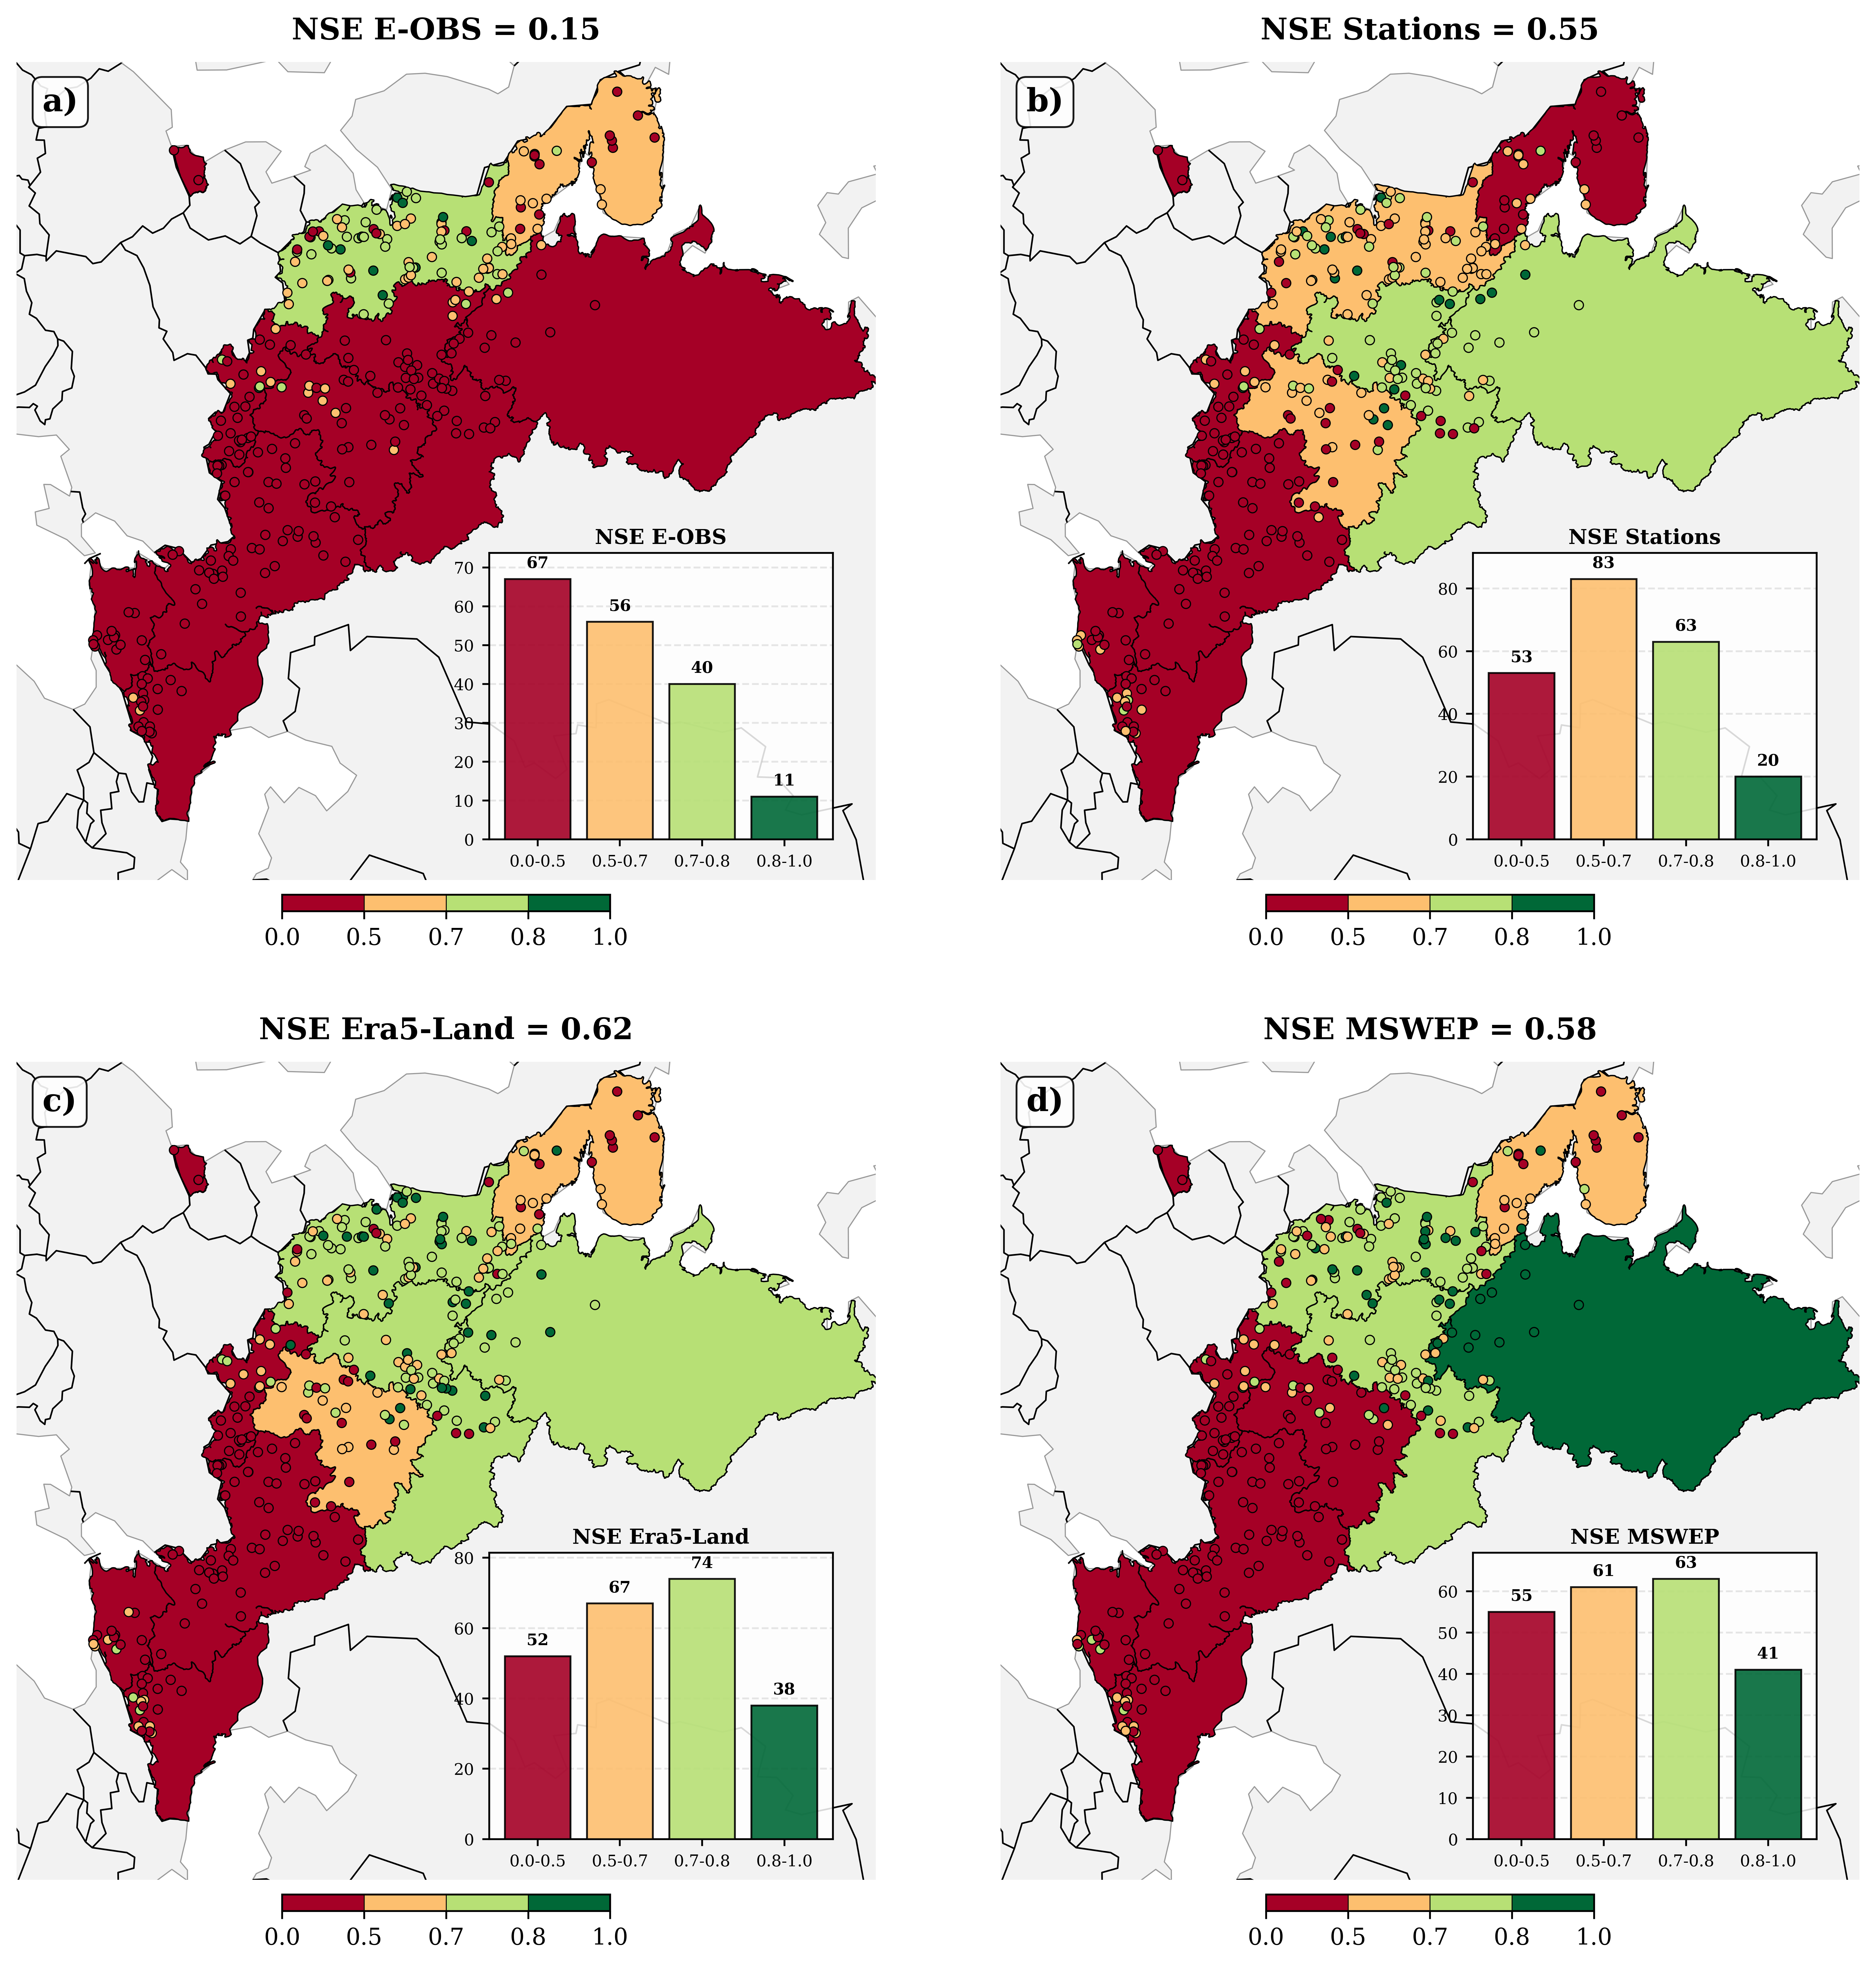

In [252]:
russia_plots_n(
    gdf_to_plot=gr4j_metrics,
    basemap_data=basemap_data,
    rus_extent=[40, 50, 40, 75],
    columns_from_gdf=[
        "NSE E-OBS",
        "NSE Stations",
        "NSE Era5-Land",
        "NSE MSWEP",
    ],
    title_text=[
        f"NSE E-OBS = {gr4j_metrics['NSE E-OBS'].median():.2f}",
        f"NSE Stations = {gr4j_metrics['NSE Stations'].median():.2f}",
        f"NSE Era5-Land = {gr4j_metrics['NSE Era5-Land'].median():.2f}",
        f"NSE MSWEP = {gr4j_metrics['NSE MSWEP'].median():.2f}",
    ],
    hist_name=["NSE E-OBS", "NSE Stations", "NSE Era5-Land", "NSE MSWEP"],
    figsize=(15, 15),
    nrows=2,
    ncols=2,
    label_list=["a)", "b)", "c)", "d)"],
    ugms=True,
    ugms_gdf=basin_districts.dropna(),
    with_histogram=True,
);

In [ ]:
gr4j_results = {}
color_obs = "#1f77b4"  # Blue for observed discharge
color_sim = "#ff7f0e"  # Orange for simulated discharge
color_lvl = "#2ca02c"  # Green for water level

for dataset in METEO_DATASETS:
    gr4j_results[dataset] = []
    for gauge_id in full_gauges:
        with open(
            f"/home/dmbrmv/Development/HydroEPRF/data/res/gr4j_optuna/{gauge_id}/{gauge_id}_{dataset}/best_parameters.json"
        ) as f:
            gr4j_params = json.load(f)

        point_geom = e_obs_gauges.loc[gauge_id, "geometry"]
        latitude = float(point_geom.y)
        hydro_file = pd.read_csv(
            f"../data/HydroFiles/{gauge_id}.csv", parse_dates=["date"], index_col="date"
        )[["q_mm_day", "lvl_sm"]]
        if dataset == "mswep":
            with xr.open_dataset(f"../data/MeteoData/ProcessedGauges/{dataset}/res/{gauge_id}.nc") as ds:
                mswep_file = ds.to_dataframe()
            # Load ERA5-Land data and merge with MSWEP
            with xr.open_dataset(f"../data/MeteoData/ProcessedGauges/era5_land/res/{gauge_id}.nc") as ds:
                meteo_file = ds.to_dataframe()
            meteo_file.loc[:, "prcp"] = mswep_file.loc[:, "prcp"]
        else:
            with xr.open_dataset(f"../data/MeteoData/ProcessedGauges/{dataset}/res/{gauge_id}.nc") as ds:
                meteo_file = ds.to_dataframe()
        if "t_mean" not in meteo_file.columns:
            # Calculate mean temperature
            meteo_file["t_mean"] = (meteo_file["t_max"] + meteo_file["t_min"]) / 2

        # Merge hydro and meteo data and filter to period of interest
        gr4j_data = pd.concat([hydro_file, meteo_file], axis=1).loc["2008":, :]
        # Calculate PET using Oudin formula - convert to lists for type compatibility
        t_mean_list = gr4j_data["t_mean"].tolist()
        day_of_year_list = [int(d) for d in gr4j_data["day_of_year"].tolist()]
        gr4j_data["pet_mm_day"] = pet_oudin(t_mean_list, day_of_year_list, latitude)
        gr4j_data = gr4j_data.loc[validation_period[0] : validation_period[1], :]

        gr4j_data["q_pred"] = gr4j_simulation(data=gr4j_data, params=list(gr4j_params.values()))
        exmp_data = gr4j_data[["q_mm_day", "q_pred"]]

        # Plot observed/simulated discharge and water level on a single plot with dual y-axes
        fig, ax1 = plt.subplots(figsize=(12, 5))

        # Plot observed and simulated discharge on the primary y-axis
        ax1.set_xlabel("Date")
        ax1.set_ylabel("Discharge, mm/day", color=color_obs)
        ax1.plot(exmp_data.index, exmp_data["q_mm_day"], color=color_obs, label="Observed, mm/day")
        ax1.plot(
            exmp_data.index,
            exmp_data["q_pred"],
            color=color_sim,
            label="Simulated, mm/day",
            linestyle="--",
        )
        ax1.tick_params(axis="y", labelcolor=color_obs)
        ax1.legend(loc="upper left")

        # Create a secondary y-axis for water level
        ax2 = ax1.twinx()
        ax2.set_ylabel("Water level, sm", color=color_lvl)
        ax2.scatter(
            hydro_file.loc[validation_period[0] : validation_period[1]].index,
            hydro_file.loc[validation_period[0] : validation_period[1], "lvl_sm"],
            color=color_lvl,
            label="Water Level, sm",
            alpha=0.6,
            s=6,
        )
        ax2.tick_params(axis="y", labelcolor=color_lvl)
        ax2.legend(loc="upper right")

        metric_str = ", ".join([f"{k}: {v:.3f}" for k, v in gauge_metric.items()])
        fig.suptitle(f"Gauge {gauge_id} - {e_obs_gauges.loc[gauge_id, 'name_ru']}\n{metric_str}")
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])

        # Save plot to disk
        plot_dir = Path("../images/") / "gr4j"
        plot_dir.mkdir(parents=True, exist_ok=True)
        plot_path = plot_dir / f"{gauge_id}_{dataset}_discharge_level.png"
        fig.savefig(plot_path, dpi=150)
        plt.close(fig)
        gauge_metric = evaluate_model(observed=exmp_data["q_mm_day"], simulated=exmp_data["q_pred"])
        gr4j_results[dataset].append(pd.DataFrame(gauge_metric, index=[gauge_id]))

In [ ]:
for meteo_dataset in METEO_DATASETS:
    for gauge_id in full_gauges:
        # Get the relevant data and parameters for this dataset
        with open(
            f"../data/res/gr4j_optuna/{gauge_id}/{gauge_id}_{meteo_dataset}/best_parameters.json"
        ) as f:
            gr4j_params = json.load(f)

        # Load hydro data
        hydro_file = pd.read_csv(
            f"../data/HydroFiles/{gauge_id}.csv", parse_dates=["date"], index_col="date"
        )[["q_mm_day", "lvl_sm"]]

        # Load and process meteo data based on dataset
        if meteo_dataset == "mswep":
            with xr.open_dataset(
                f"../data/MeteoData/ProcessedGauges/{meteo_dataset}/res/{gauge_id}.nc"
            ) as ds:
                mswep_file = ds.to_dataframe()
            with xr.open_dataset(f"../data/MeteoData/ProcessedGauges/era5_land/res/{gauge_id}.nc") as ds:
                meteo_file = ds.to_dataframe()
            meteo_file.loc[:, "prcp"] = mswep_file.loc[:, "prcp"]
        else:
            with xr.open_dataset(
                f"../data/MeteoData/ProcessedGauges/{meteo_dataset}/res/{gauge_id}.nc"
            ) as ds:
                meteo_file = ds.to_dataframe()

        if "t_mean" not in meteo_file.columns:
            meteo_file["t_mean"] = (meteo_file["t_max"] + meteo_file["t_min"]) / 2

        # Get gauge location for PET calculation
        point_geom = e_obs_gauges.loc[gauge_id, "geometry"]
        latitude = float(point_geom.y)

        # Prepare data for simulation
        gr4j_data = pd.concat([hydro_file, meteo_file], axis=1).loc["2008":, :]
        t_mean_list = gr4j_data["t_mean"].tolist()
        day_of_year_list = [int(d) for d in gr4j_data["day_of_year"].tolist()]
        gr4j_data["pet_mm_day"] = pet_oudin(t_mean_list, day_of_year_list, latitude)
        gr4j_data = gr4j_data.loc[selection_period[0] : selection_period[1], :]
        # Run simulation
        gr4j_data["q_pred"] = gr4j_simulation(data=gr4j_data, params=list(gr4j_params.values()))
        exmp_data = gr4j_data.loc[validation_period[0] : validation_period[1], ["q_mm_day", "q_pred"]]
        # Calculate metrics for this simulation
        gauge_metric = evaluate_model(observed=exmp_data["q_mm_day"], simulated=exmp_data["q_pred"])
        with open(
            f"../data/res/gr4j_optuna/{gauge_id}/{gauge_id}_{meteo_dataset}/metrics.json", "w"
        ) as f:
            json.dump(gauge_metric, f)

In [240]:
# Define dataset order and corresponding titles
datasets = ["e_obs", "meteo_ru_nc_02", "era5_land", "mswep"]
dataset_titles = ["E-OBS", "Weather Stations", "ERA5-Land", "MSWEP"]

for gauge_id in full_gauges:
    # Create a figure for comparing all datasets
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    for i, (dataset, title) in enumerate(zip(datasets, dataset_titles)):
        # Get the relevant data and parameters for this dataset
        with open(f"../data/res/gr4j_optuna/{gauge_id}/{gauge_id}_{dataset}/best_parameters.json") as f:
            gr4j_params = json.load(f)

        # Load hydro data
        hydro_file = pd.read_csv(
            f"../data/HydroFiles/{gauge_id}.csv", parse_dates=["date"], index_col="date"
        )[["q_mm_day", "lvl_sm"]]

        # Load and process meteo data based on dataset
        if dataset == "mswep":
            with xr.open_dataset(f"../data/MeteoData/ProcessedGauges/{dataset}/res/{gauge_id}.nc") as ds:
                mswep_file = ds.to_dataframe()
            with xr.open_dataset(f"../data/MeteoData/ProcessedGauges/era5_land/res/{gauge_id}.nc") as ds:
                meteo_file = ds.to_dataframe()
            meteo_file.loc[:, "prcp"] = mswep_file.loc[:, "prcp"]
        else:
            with xr.open_dataset(f"../data/MeteoData/ProcessedGauges/{dataset}/res/{gauge_id}.nc") as ds:
                meteo_file = ds.to_dataframe()

        if "t_mean" not in meteo_file.columns:
            meteo_file["t_mean"] = (meteo_file["t_max"] + meteo_file["t_min"]) / 2

        # Get gauge location for PET calculation
        point_geom = e_obs_gauges.loc[gauge_id, "geometry"]
        latitude = float(point_geom.y)

        # Prepare data for simulation
        gr4j_data = pd.concat([hydro_file, meteo_file], axis=1).loc["2008":, :]
        t_mean_list = gr4j_data["t_mean"].tolist()
        day_of_year_list = [int(d) for d in gr4j_data["day_of_year"].tolist()]
        gr4j_data["pet_mm_day"] = pet_oudin(t_mean_list, day_of_year_list, latitude)
        gr4j_data = gr4j_data.loc[selection_period[0] : selection_period[1], :]

        # Run simulation
        gr4j_data["q_pred"] = gr4j_simulation(data=gr4j_data, params=list(gr4j_params.values()))
        exmp_data = gr4j_data.loc[validation_period[0] : validation_period[1], ["q_mm_day", "q_pred"]]

        # Calculate metrics for this simulation
        gauge_metric = evaluate_model(observed=exmp_data["q_mm_day"], simulated=exmp_data["q_pred"])
        metric_str = f"R² = {gauge_metric['R2']:.3f}, NSE = {gauge_metric['NSE']:.3f}"

        # Plot on the appropriate subplot
        ax1 = axes[i]

        # Plot discharge
        ax1.plot(exmp_data.index, exmp_data["q_mm_day"], color=color_obs, label="Observed")
        ax1.plot(
            exmp_data.index, exmp_data["q_pred"], color=color_sim, label="Simulated", linestyle="--"
        )

        # Add water level as secondary y-axis
        ax2 = ax1.twinx()
        ax2.scatter(
            hydro_file.loc[validation_period[0] : validation_period[1]].index,
            hydro_file.loc[validation_period[0] : validation_period[1], "lvl_sm"],
            color=color_lvl,
            alpha=0.3,
            s=6,
            label="Water Level",
        )

        # Set labels and title
        ax1.set_xlabel("Date")
        ax1.set_ylabel("Discharge, mm/day", color=color_obs)
        ax2.set_ylabel("Water level, sm", color=color_lvl)
        ax1.set_title(f"{title}\n{metric_str}")

        # Only show legend on the first subplot to avoid repetition
        if i == 0:
            lines1, labels1 = ax1.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

    # Set common title and adjust layout
    fig.suptitle(
        f"Gauge {gauge_id} - {e_obs_gauges.loc[gauge_id, 'name_ru']}\nComparison of Meteorological Datasets (2019-2022)",
        fontsize=16,
    )
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Save the comparison plot
    plot_dir = Path("../images/") / "gr4j_comparison"
    plot_dir.mkdir(parents=True, exist_ok=True)
    fig.savefig(plot_dir / f"{gauge_id}_dataset_comparison.png", dpi=300)
    plt.close(fig)
